# DLC Postprocess Library

Run after training has been performed, and at least 1 video has been analyzed

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import h5py
import json
import os
import copy

from IPython.display import display, HTML

%load_ext autoreload
%autoreload 2

from lib.qt_wrapper import gui_fname, gui_fnames, gui_fpath
from lib.parse_dlc_results import dlc_csv_composite_crawl
from lib.hdf5_wrapper import npStrArr2h5
from lib.constraints import compute_constraints
# from lib.plots import plotStatistics
from lib.stickman import stickman

# from lib.sampling import selectUniform
# from lib.hdf5_wrapper import npStrArr2h5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Merge trial-based DLC results into session-based

1. Provide root directory for videos and tracking
2. Provide output folder
3. Merged files will be written into output folder (with no further subfolder structure)
  * Name of an output file will be the folder name the trials are contained in
  * Code will throw an exception (crash) if
    - number of videos and tracking files does not match
    - framerate changes during the session
    - tracked nodes do not have exact same names during the session

In [28]:
root_crawl_path = gui_fpath("Select path for crawler", "./")
output_path = gui_fpath("Select output path", root_crawl_path)

In [29]:
dlc_csv_composite_crawl(root_crawl_path, output_path)

Finding paths to CSV and AVI files
Processing folder 0 / 25 ; Have 658 files
[100%] parsing CSV Files
[100%] getting FPS infogetting FPS info
-- computing merged file
-- writing merged data of 658 videos to /home/hpc_user/data/yaro_dlc_results/mtp_12_2017_01_10_a.h5
Processing folder 1 / 25 ; Have 534 files
[100%] parsing CSV Files
[100%] getting FPS info
-- computing merged file
-- writing merged data of 534 videos to /home/hpc_user/data/yaro_dlc_results/mtp_12_2017_01_11_a.h5
Processing folder 2 / 25 ; Have 940 files
[100%] parsing CSV Files
[100%] getting FPS info
-- computing merged file
-- writing merged data of 940 videos to /home/hpc_user/data/yaro_dlc_results/mtp_13_2017_03_09_a.h5
Processing folder 3 / 25 ; Have 760 files
[100%] parsing CSV Files
[100%] getting FPS info
-- computing merged file
-- writing merged data of 760 videos to /home/hpc_user/data/yaro_dlc_results/mtp_13_2017_03_10_a.h5
Processing folder 4 / 25 ; Have 248 files
[100%] parsing CSV Files
[100%] getting FPS

In [ ]:
# OLD: Remove useless directories
fnames_h5 = gui_fnames("h5", "./", "HDF5 (*.h5)")
for i, fname_h5 in enumerate(fnames_h5):
    print(i, '/', len(fnames_h5))
    with h5py.File(fname_h5, "a") as dlc_h5_file:
        dlc_h5_file.attrs['VID_PATH'] = np.string_(os.path.dirname(dlc_h5_file['VID_PATHS'][0]))
        npStrArr2h5(dlc_h5_file, [os.path.basename(vidpathname) for vidpathname in dlc_h5_file['VID_PATHS']], "VID_NAMES")
        del dlc_h5_file['VID_PATHS']
        del dlc_h5_file['CSV_PATHS']

# Analyse a session-based DLC results file

In [78]:
param = {}
param["H5_FNAME"]  = gui_fname("Open DLC session results file", "./", "HDF5 files (*.h5)")
param["TMP_FNAME"] = gui_fname("Select Postprocess Template Filename...", "./", "Template Files (*.json)")
param["REZ_FPATH"] = gui_fpath("Select result path", "./")

In [79]:
#########################
# Parse JSON file
#########################
with open(param["TMP_FNAME"]) as json_file:
    param.update(json.load(json_file))

### Some basic data about the data set

Original path /media/hpc_user/MyBook6/whisk_video/mtp_10/mtp_10_2016_09_07_a


,mtp_10_2016_09_07_a.h5
Framerate,200.0
Maximal number of time steps,1952.0
Number of tracked nodes,9.0
Number of trials,822.0


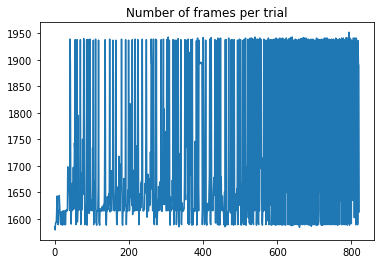

In [106]:
dlc_h5_file = h5py.File(param["H5_FNAME"], "r")
NODE_NAMES = np.array(dlc_h5_file['NODE_NAMES'])
N_TIMES_MAX, N_NODES, N_TRIALS = dlc_h5_file['X'].shape
FPS = float(np.array(dlc_h5_file['FPS']))
VID_PATH = np.string_(dlc_h5_file.attrs['VID_PATH']).decode()
timesArr = np.arange(N_TIMES_MAX) / FPS

print("Original path", VID_PATH)
display(pd.DataFrame({
    "Framerate"                    : FPS,
    "Maximal number of time steps" : N_TIMES_MAX,
    "Number of tracked nodes"      : N_NODES,
    "Number of trials"             : N_TRIALS
}, index=(os.path.basename(param["H5_FNAME"]),)).T)

# Determine video length
N_TIMES_BY_TRIAL = np.sum(1 - np.isnan(dlc_h5_file['X'][:, 0, :]), axis=0)
plt.figure()
plt.title("Number of frames per trial")
plt.plot(N_TIMES_BY_TRIAL)
plt.show()

### Quality control

**TODO**:
<font color='red' size='3'>
* Integrate velocity and edge length criteria
</font>

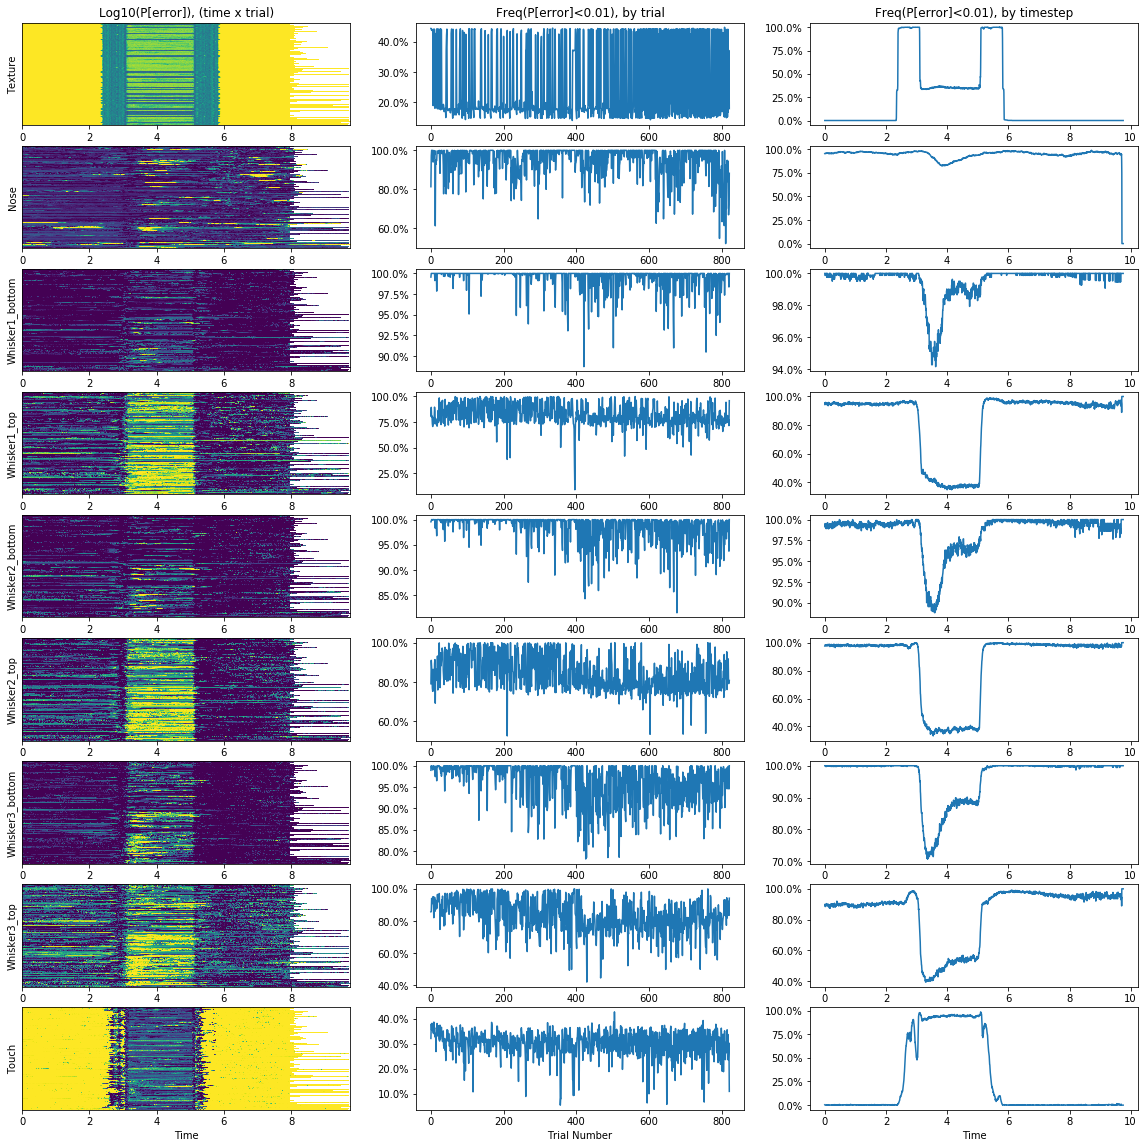

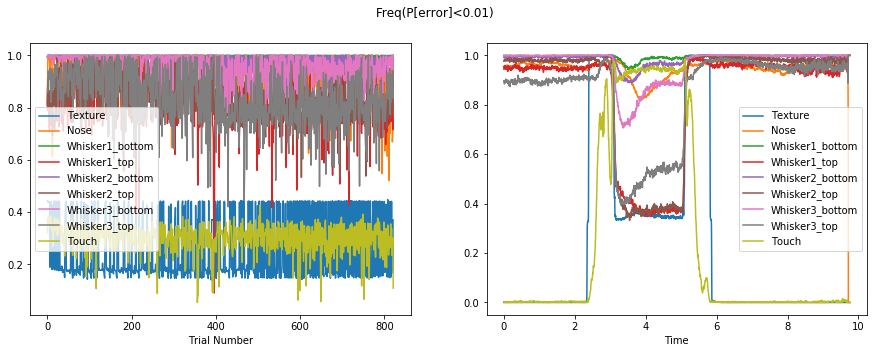

In [94]:
P_THR = 0.01  # P-Value cutoff

fig, ax = plt.subplots(nrows=N_NODES, ncols=3, figsize=(20,20))
fig2, ax2 = plt.subplots(ncols=2, figsize=(15,5))
for iNode in range(N_NODES):
    P_ERR = 1 - np.array(dlc_h5_file['P'][:, iNode, :]).T
    P_ERR_NONAN = np.copy(P_ERR)
    P_ERR_NONAN[np.isnan(P_ERR_NONAN)] = 1
    F_ERR_TEX  = np.sum(P_ERR_NONAN < P_THR, axis=0) / np.sum(1 - np.isnan(P_ERR), axis=0)
    F_ERR_TIME = np.sum(P_ERR_NONAN < P_THR, axis=1) / np.sum(1 - np.isnan(P_ERR), axis=1)
    P_ERR[P_ERR == 0] = 1.0e-15
    
    ax[iNode][0].imshow(np.log10(P_ERR), vmin=-6, vmax=0, extent=[0, N_TIMES_MAX / FPS, 0, N_TRIALS], aspect='auto')
    ax[iNode][0].set_ylabel(NODE_NAMES[iNode])
    #ax[iNode][0].get_xaxis().set_ticks([])
    ax[iNode][0].get_yaxis().set_ticks([])
    
    ax[iNode][1].plot(F_ERR_TIME)
    ax[iNode][2].plot(timesArr, F_ERR_TEX)
    ax[iNode][1].set_yticklabels(['{:,.1%}'.format(x) for x in ax[iNode][1].get_yticks()])
    ax[iNode][2].set_yticklabels(['{:,.1%}'.format(x) for x in ax[iNode][2].get_yticks()])
    
    ax2[0].plot(F_ERR_TIME, label=NODE_NAMES[iNode])
    ax2[1].plot(timesArr, F_ERR_TEX,  label=NODE_NAMES[iNode])
    
    if iNode==0:
        ax[iNode][0].set_title("Log10(P[error]), (time x trial)")
        ax[iNode][1].set_title("Freq(P[error]<0.01), by trial")
        ax[iNode][2].set_title("Freq(P[error]<0.01), by timestep")
        
ax[-1][0].set_xlabel("Time")
ax[-1][1].set_xlabel("Trial Number")
ax[-1][2].set_xlabel("Time")
   
fig2.suptitle("Freq(P[error]<0.01)")
ax2[0].set_xlabel("Trial Number")
ax2[1].set_xlabel("Time")
ax2[0].legend()
ax2[1].legend()
plt.show()

## First Touch

**TODO**:
<font color='red' size='3'>
* Decide if P=0.01 is a good measure of confidence for first touch
* Decide if first occurence of confident touch is an adequate measure of the first touch
</font>

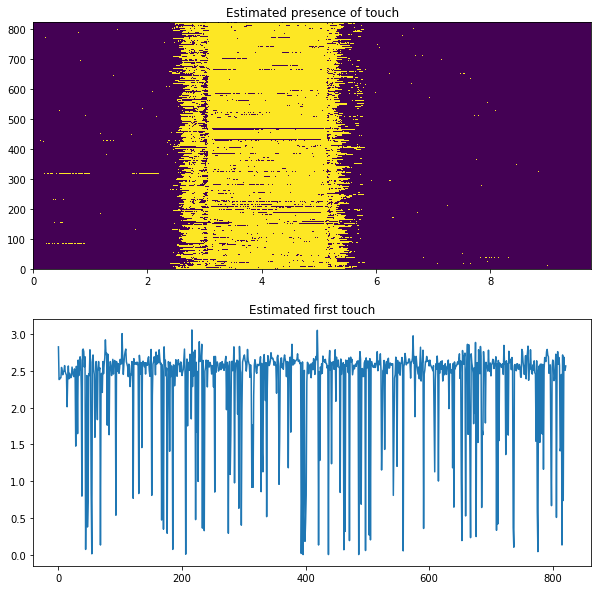

In [100]:
P_THR_TOUCH = 0.01
IDX_TOUCH = np.where(NODE_NAMES=="Touch")[0][0]
P_ERR_TOUCH = 1 - np.array(dlc_h5_file['P'][:, IDX_TOUCH, :]).T
P_ERR_TOUCH[np.isnan(P_ERR_TOUCH)] = 1
HAVE_TOUCH = P_ERR_TOUCH < P_THR_TOUCH

first_touch = np.full(N_TRIALS, np.nan)
for iTrial in range(N_TRIALS):
    candidates = np.where(HAVE_TOUCH[iTrial])[0]
    if len(candidates) > 0:
        first_touch[iTrial] = np.min(candidates)
    
# Convert first touch from bin number to time
first_touch /= FPS

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
ax[0].set_title("Estimated presence of touch")
ax[1].set_title("Estimated first touch")
ax[0].imshow(HAVE_TOUCH, aspect='auto', extent=[0, N_TIMES_MAX / FPS, 0, N_TRIALS])
ax[1].plot(first_touch)
plt.show()

## Stickman

In [41]:
TRIAL_IDX = 0   # Index of trial we want to stickman
X_THIS = dlc_h5_file['X'][:N_TIMES_BY_TRIAL[TRIAL_IDX], :, TRIAL_IDX]
Y_THIS = dlc_h5_file['Y'][:N_TIMES_BY_TRIAL[TRIAL_IDX], :, TRIAL_IDX]
P_THIS = dlc_h5_file['P'][:N_TIMES_BY_TRIAL[TRIAL_IDX], :, TRIAL_IDX]

constr_dict = compute_constraints(X_THIS, Y_THIS, P_THIS, param)
display(constr_dict["summary"])

param_thistrial = copy.deepcopy(param)
param_thistrial['AVI_FNAME'] = os.path.join(VID_PATH, dlc_h5_file['VID_NAMES'][TRIAL_IDX]) 
#param_thistrial['AVI_FNAME'] = "/media/hpc_user/MyBook123/whisk_video/mvg_2/mvg_2_2017_08_31_a/2017_08_31_11_01_32.avi"

stickman(X_THIS, Y_THIS, param_thistrial, constr_dict, fps=FPS)

(1624, 9) (1623, 9)
Skipping edge constraint as no edges provided
bool bool
(1624, 9) (1624, 9)


,Low confidence,High velocity 1 neighbour,High velocity 2 neighbours,All the above combined
Nodes,0,1248,322,1248
Frames,0,884,296,884


Writing video [1624/1624]
Done!
